# Comparing Model Resolution

Load and explore model solutions at a range of horizontal resolutions (1°, 0.25°, and 0.1°). We use snapshots of model output to explore how the velocity fields differ between the simulations. We also look at eddy kinetic energy, which highlights that coarser resolution simulations have less variability in their velocity fields.

In [1]:
import intake
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import pint_xarray
from pint import application_registry as ureg

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft

Given that the high resolution simulations contain quite a lot of data, let's fire up a Dask cluster to parallelise the computation.

In [2]:
from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46405,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:38331,Total threads: 1
Dashboard: http://127.0.0.1:36697/status,Memory: 15.71 GiB
Nanny: tcp://127.0.0.1:38309,


In [3]:
catalog = intake.cat.access_nri

Pick three experiments to analyse. If you want to look at a list of all the experiments available, run the following snippet.

`catalog.search(model="ACCESS-OM2")`

In [4]:
experiments = ['01deg_jra55v140_iaf_cycle4',
               '025deg_jra55_iaf_omip2_cycle6',
               '1deg_jra55_iaf_omip2_cycle6']

titles      = ['0.1° horizontal resolution',
               '0.25° horizontal resolution',
               '1° horizontal resolution']

For simplicity, here we load only 3 years of data. But you may load as much as you like! Also we only load one depth level, in particular the one prescribed with variable `depth` below.

In [5]:
start_time = '1980-01'
end_time = '1982-12'
depth = 0

In [6]:
sims = {}

for experiment in experiments:
    ds = xr.merge([
        catalog[experiment].search(variable=iVar, variable_cell_methods = "time: mean").to_dask() for iVar in ['u', 'v']
    ])

    #correct the cf attributes
    ds.xu_ocean.attrs['standard_name'] = 'grid_longitude'
    ds.xu_ocean.attrs['units'] = 'degree'
    ds.yu_ocean.attrs['standard_name'] = 'grid_latitude'
    ds.yu_ocean.attrs['units'] = 'degree'
    
    #select depth and time of interest
    ds = ds.cf.sel(vertical=depth, method='nearest').sel(time=slice(start_time, end_time))
    
    # attach units to datasets using pint
    ds = ds.pint.quantify()
    
    # calculate eddy kinetic energy
    ds['speed'] = np.sqrt(ds.u**2 + ds.v**2)
    ds['eke'] = 1/2 * ((ds.u - ds.u.mean(dim='time'))**2 + (ds.v - ds.v.mean(dim='time'))**2)

    ds = ds.chunk(time=-1)
    sims[experiment] = ds


Having selected the data, let's plot some output from each simulation and look at the differences. We select the final time of the loaded data to plot.

First we load the land that we'll use in all plots.

In [7]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor='black', facecolor='lightgray', linewidth=0.5)

The following plots are snapshots of zonal velocity. All three simulations show roughly the same results, with westward and eastward flows occuring in approximately the same locations. However, the 0.1° and 0.25° simulations show mesoscale variability that is entirely lacking from the 1° simulation.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


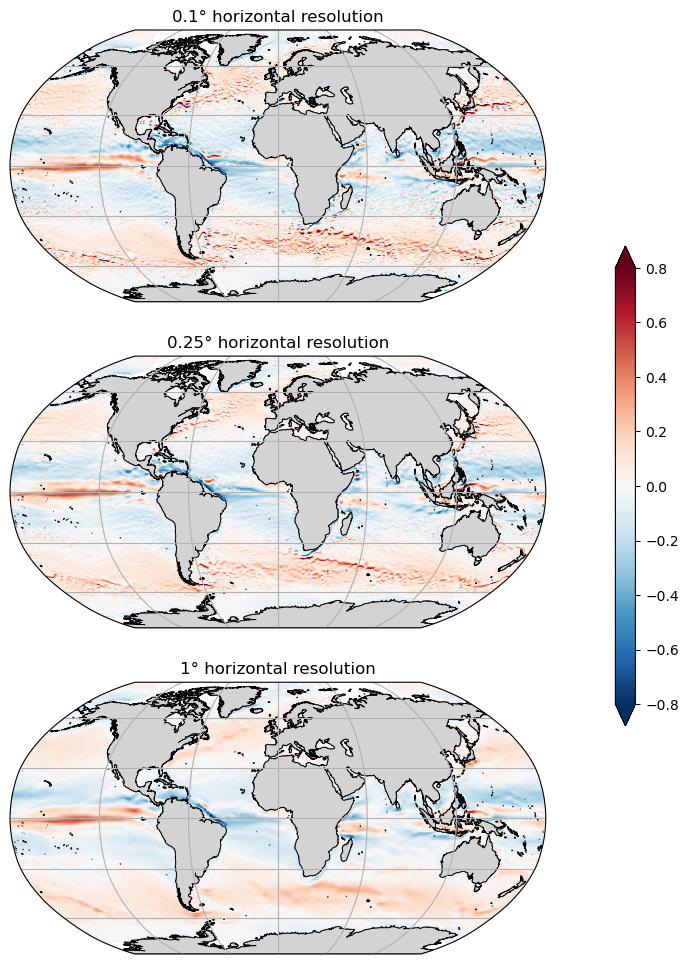

In [8]:
fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw = {'projection': ccrs.Robinson()})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.gridlines(draw_labels=False)
    
    u_snapshot = sims[experiment].u.isel(time=-1)
    
    p = u_snapshot.cf.plot(ax = ax,
                           x='grid_longitude',
                           y='grid_latitude',
                           transform=ccrs.PlateCarree(),
                           cmap='RdBu_r', vmin=-0.8, vmax=0.8,
                           add_colorbar=False)

    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='both', label=u_snapshot.pint.units);

The mesoscale variability hinted at in the above global figures is more easily seen by zooming into a regional scale. The plots below show the Atlantic sector of the Southern Ocean, including the Agulhas Current, and Drake Passage. The figures below also show that higher horizontal resolution support much higher flow speeds.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


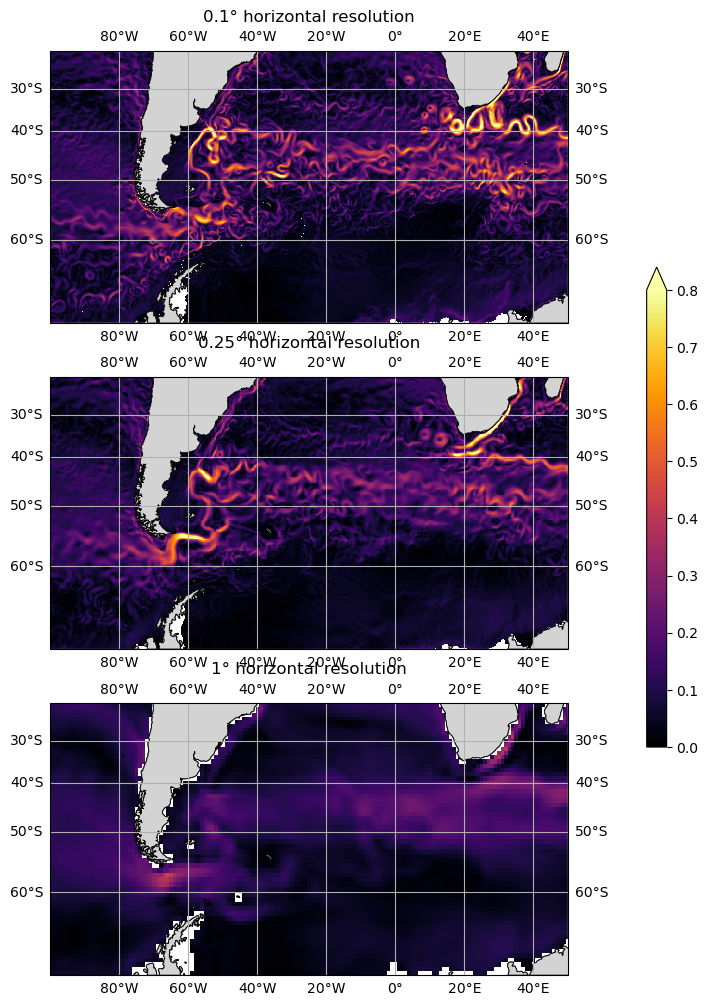

In [9]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw = {'projection': projection})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    speed_snapshot = sims[experiment].speed.isel(time=-1)
    
    p = speed_snapshot.cf.plot(ax=ax,
                               x='grid_longitude',
                               y='grid_latitude',
                               transform=ccrs.PlateCarree(),
                               cmap='inferno', vmin=0, vmax=0.8,
                               add_colorbar=False)

    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='max', label=speed_snapshot.pint.units);

The higher resolution simulations exhibit much more variability in their velocity fields. This can be easily seen by looking at eddy kinetic energy, defined as 

$$\text{EKE} = \frac1{2} \big[ (u - \overline{u})^{2} + (v-\overline{v})^{2} \big]$$

where overbar denotes a time average. Eddy kinetic energy picks out variability in the velocity fields. Again, we plot the final timestamp.

This plot takes quite some time to produce, since it requires averaging the entire time series of `u` and `v` for each simulation.

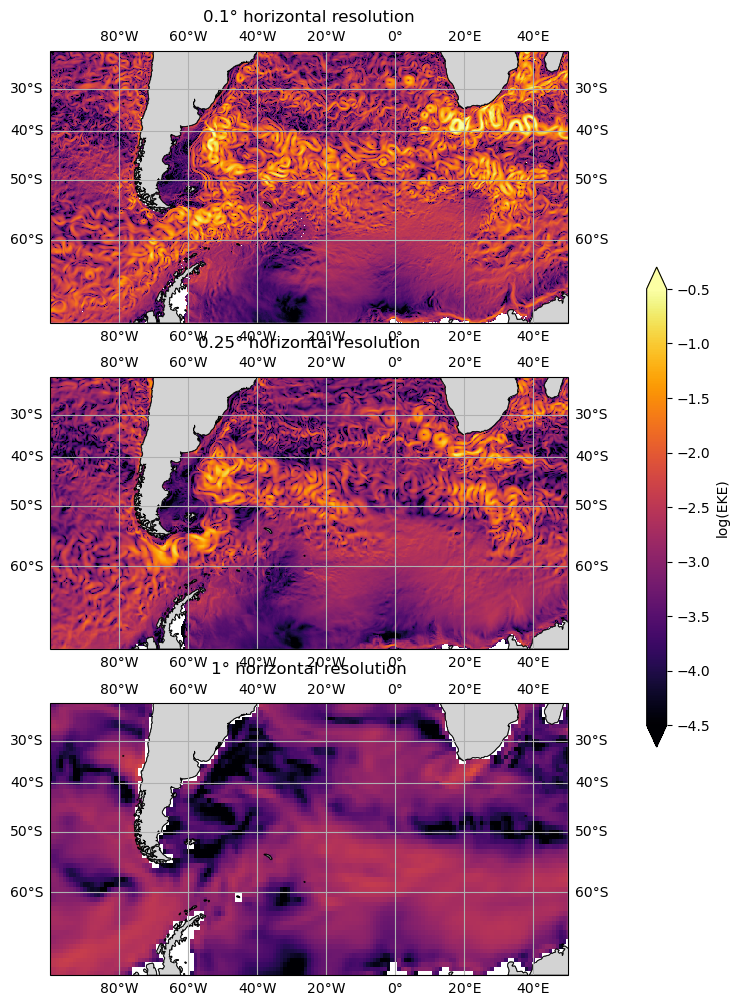

In [10]:
projection=ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

fig, axes = plt.subplots(nrows = 3, figsize = (10, 12),
                         subplot_kw = {'projection': projection})

for counter, experiment in enumerate(experiments):
    ax = axes[counter]
    ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    
    eke_snapshot = sims[experiment].eke.isel(time=-1)
    
    log10eke = np.log10(eke_snapshot.pint.dequantify()) # can't take logarithm of quantity with units
    
    p = log10eke.cf.plot(ax=ax,
                         x='grid_longitude',
                         y='grid_latitude',
                         transform=ccrs.PlateCarree(),
                         cmap='inferno', vmin=-4.5, vmax=-0.5,
                         add_colorbar=False)
    
    ax.set_title(titles[counter])

ax_cb = plt.axes([0.85, 0.3, 0.02, 0.4])
plt.colorbar(p, cax=ax_cb, extend='both', label='log(EKE)');

In [11]:
client.close()